In [14]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
df = pd.read_csv('../data/raw/consumer_complaints.csv')
df.head()

C:\Users\a.laemmel\AppData\Local\Temp\ipykernel_20864\2303425950.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/consumer_complaints.csv')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [3]:
print(f"Nb rows: {len(df)}")
print(f"Nb unique dates: {len(df['date_received'].unique())} from {min(df['date_received'])} to {max(df['date_received'])}")
print(f"Products (y): {len(df['product'].unique())} in total {df['product'].unique()}")
print(f"Nb rows with not NaN consumer_complaint_narrative: {len(df[df['consumer_complaint_narrative'].notna()])}")

Nb rows: 555957
Nb unique dates: 1608 from 01/01/2012 to 12/31/2015
Products (y): 11 in total ['Mortgage' 'Credit reporting' 'Student loan' 'Debt collection'
 'Credit card' 'Bank account or service' 'Consumer Loan' 'Money transfers'
 'Payday loan' 'Prepaid card' 'Other financial service']
Nb rows with not NaN consumer_complaint_narrative: 66806


In [4]:
df_notna = df[df['consumer_complaint_narrative'].notna()].reset_index(drop=True)
df_notna.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
3,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
4,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137


In [5]:
hist_product = pd.DataFrame(df_notna.groupby('product')['complaint_id'].count()).sort_values(by='complaint_id', ascending=False)
hist_product = hist_product.rename(columns={'complaint_id': 'count'})
hist_product['percent'] = hist_product['count'] / hist_product['count'].sum()
hist_product

,count,percent
product,,
Debt collection,17552,0.262731
Mortgage,14919,0.223318
Credit reporting,12526,0.187498
Credit card,7929,0.118687
Bank account or service,5711,0.085486
Consumer Loan,3678,0.055055
Student loan,2128,0.031853
Prepaid card,861,0.012888
Payday loan,726,0.010867


<BarContainer object of 11 artists>

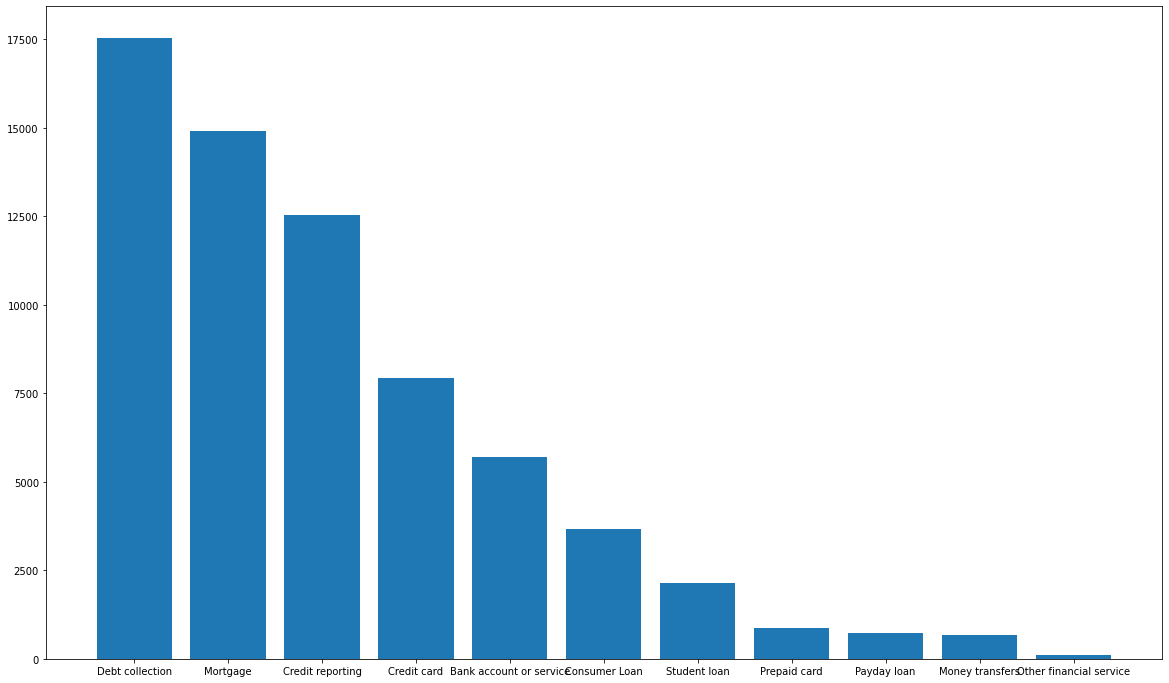

In [6]:
plt.figure(figsize=(20,12))
plt.bar(hist_product.index, hist_product['count'])

Mortgage


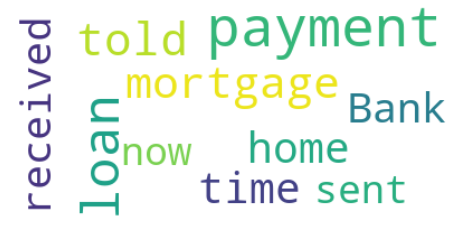

Credit reporting


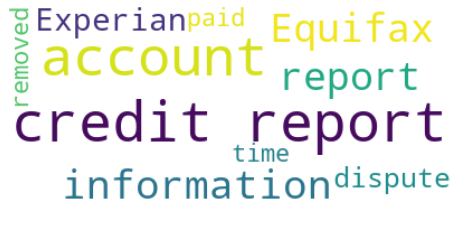

Student loan


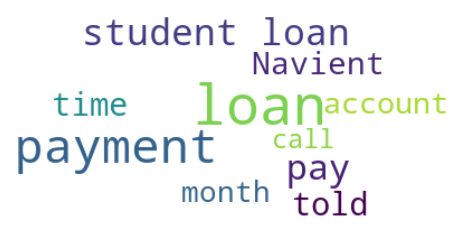

Debt collection


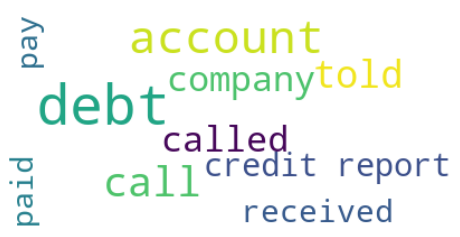

Credit card


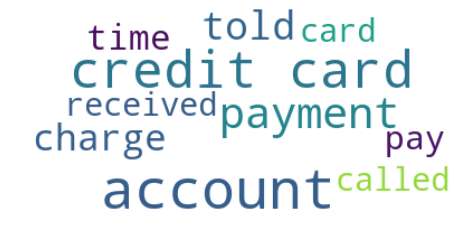

Bank account or service


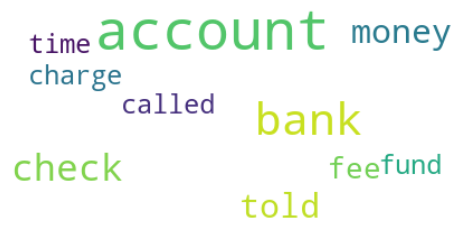

Consumer Loan


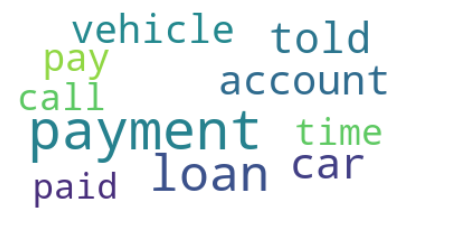

Money transfers


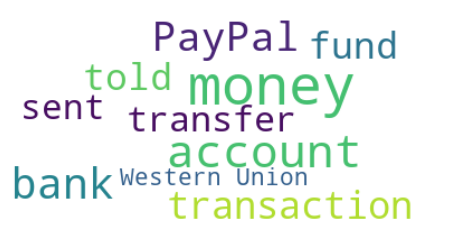

Payday loan


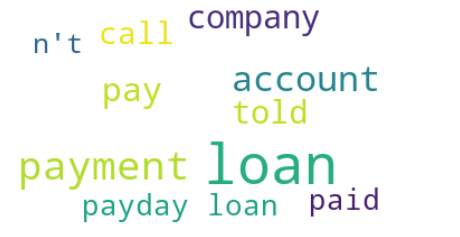

Prepaid card


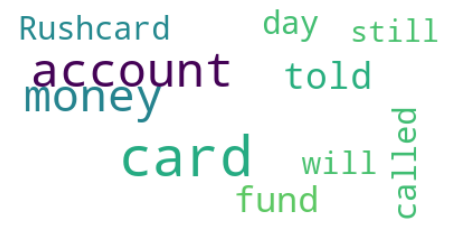

Other financial service


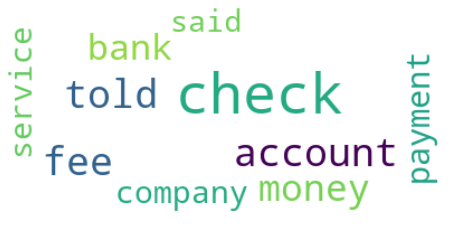

In [7]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["XXXX", "XX"])

for product in df['product'].unique():
    df_product = df_notna[df_notna['product'] == product]

    # Concatenate all text
    text = df_product['consumer_complaint_narrative'].str.cat()

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=10, background_color="white").generate(text)
    
    print(f"{product}")
    # Display the generated image:
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [8]:
train, test = train_test_split(df_notna, random_state=42)
print(f"Nb rows in train: {len(train)}")
print(f"Nb rows in train: {len(test)}")

Nb rows in train: 50104
Nb rows in train: 16702


In [9]:
le = preprocessing.LabelEncoder()
train["label"] = le.fit_transform(train["product"])
test["label"] = le.transform(test["product"])

In [10]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['consumer_complaint_narrative'])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

nb = MultinomialNB().fit(X=X_train_tfidf, y=train.label)

In [11]:
X_test_counts = count_vect.transform(test['consumer_complaint_narrative'])

X_test_tfidf = tfidf_transformer.transform(X_test_counts)

predicted_nb = nb.predict(X=X_test_tfidf)

In [12]:
print(f"Baseline Naive Bayes accuracy: {round(np.mean(predicted_nb == test.label) * 100, 2)}%")

Baseline Naive Bayes accuracy: 66.61%


In [16]:
lr = LogisticRegression().fit(X=X_train_tfidf, y=train.label)
predicted_lr = lr.predict(X=X_test_tfidf)
print(f"Logistic regression accuracy: {round(np.mean(predicted_lr == test.label) * 100, 2)}%")

Logistic regression accuracy: 84.86%


c:\users\a.laemmel\workspace\us-consumer-finance-complaints\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
